# Packages

In [ ]:
import collections
import json
import folium
import folium.plugins
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import gzip
import requests
import pandas as pd
import plotly.graph_objects as go
import country_converter as coco
from lingua import LanguageDetectorBuilder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import plotly.express as px


# Set font to Helvetica in matplotlib, seaborn and plotly
plt.rcParams["font.family"] = "Helvetica"

# Table of contents

1. Motivation
    1. The Datasets
    2. Why These Dataset?
    3. Goals
2. Basic Stats
    1. Data Cleaning and Preprocessing
    2. Dataset Statistics and Key Points
3. Data Analysis
    1. Exploratory Data Analysis
    2. Tree-map?
4. Genre
5. Visualization
6. Discussion
    1. Improvements and Limitations
    2. Further Work
7. Contributions
8. References

# 1. Motivation

## 1.1 The Datasets
**RateBeer Datasets**

The dataset is an overview of the user statistics of the beer enthusiast forum Ratebeer. In short, the datasets contain ~7 million reviews, ~70K users, ~440K beers, 24K breweries, which has a timespan from 2000 to 2017. 

Below are a detailed description of each attribute contained in the RateBeer datasets. These datasets include details about various beers, their breweries and locations, ratings, reviews, users, location of users etc.

### `beers.csv`

- `beer_id`: The unique identifier for each beer.
- `beer_name`: The name of the beer, which is also used in the reviews.
- `brewery_id`: The unique identifier of the brewery (also used in the reviews).
- `brewery_name` : The name of the brewery that 
- `style`: a score that ranks this beer against all beers within its own style category.
- `nbr_ratings` : The number of ratings a beer received.
- `avg`: The average rating of a beer from 0 to 5.
- `abv`: The alcohol content of the beer (percentage).
- `overall_score`: a score that reflects the rating given by RateBeer users and how this beer compares to all other beers on RateBeer. (out of 100)
- `style_score` : a score that ranks this beer against all beers within its own style category.

> These two scores are calculated only from ratings that are accompanied with a written review of 75 or more characters. A rating doesn't count toward the final rating if the rater has left fewer than 10 ratings, if it is is deemed unauthentic, derogatory or abusive or if the rating was made by a brewer or brewer affiliate. Reference [here](https://www.ratebeer.com/our-scores)


---

### `breweries.csv`

- `id` : the brewery's id which corresponds to the id *brewery_id* from `beer.csv`
- `location` : the location of the brewery
- `name` : the name of the brewery
- `nbr_beers` : the number of beers that brewery produces

---

### `users.csv`

- `user_id` : the user_id 
- `nbr_ratings` : the number of ratings the reviewer has put on the website
- `user_name` : the username
- `joined` : the date when the user joined the websites
- `location` : the user's location

--- 

### `reviews.csv`

- `beer_name` and `beer_id`: The name and unique identifier of the beer which corresponds to the ones in `beer.csv`
- `brewery_name` and `brewery_id`: The name and identifier of the brewery which corresponds to ones in `brewery.csv`.
- `style`: The type of beer, categorized into one of the beer styles (104 styles)
- `abv`: The alcohol by volume percentage of the beer (%).
- `date`: When the review was posted.
- `user_name` and `user_id`: The username and identifier of the reviewer, matching the `user.csv`.
- `text`: The written review provided by the user.

### Rating System

RateBeer employ a detailed rating system where users evaluate several aspects of the beer. The rating is composed of the following attributes:

- `appearance`
- `aroma`
- `mouthfeel`
- `taste`
- `overall`

On RateBeer, *Appearance* and *Mouthfeel* are each scored out of 5. *Aroma* and *Taste* are scored out of 10. While *Overall* is scored out of 20. These all combine to give the beer a total score out of 50, which is then divided and displayed as a score out of 5 for each rating. Reference [here](https://www.ratebeer.com/our-scores).

## Additional Data Sources Included

These datasets adds a geographical aspect to the datasets above such that the bubble plot and choropleth map can be generated. This also means that data cleaning is required, so that the countries in each dataset matches.

### Country Geometry
`https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/world-administrative-boundaries.geojson`

### Country Area [$\text{km}^2$]
`https://restcountries.com/v3.1/all`



## 1.2 Why These Datasets?
As the datasets are approx. 2.4GB in total with a heap of user information as well as for the various beers and breweries, it provides a good background for a comprehensive analysis. Additionally, the reviews comes in free-text, which provides an interesting angle, as we can apply NLP to get insights on how different or similar people from different parts of the world describe the same type of beer

## 1.3 Goals
The user should be able to get a rough idea of how the beer-review-landscape looks like and get an idea of why we have made the choices we have made, in terms of the user’s own interactive journey later in the magazine. As we have made our own conclusions on the data set, we want the user to be able to explore the data themselves and come up with their own connections, which we believe is entirely possible, due to the massive amount of exploration that one can make. Throughout the magazine, we aimed to give the user more and more interactivity the more plots they see. Starting with static plots, then introducing hover data, then dragging and zooming, and finally clicking.



# 2. Basic Stats and Preprocessing

## 2.1 Data Cleaning and Preprocessing

A couple of steps have to be done before the datasets can be used for analysis. 

### reviews.txt.gz conversion to .csv

As the BeerAdvocate text reviews are formatted inconveniently for the use of Pandas library directly, the purpose is to extract the .txt.gz file and convert it to a Pandas dateframe, which then later can be saved as in .csv format. 

In [ ]:
reviews_list=[]

with gzip.open('data/RateBeer/reviews.txt.gz', mode='rt', encoding='utf-8') as f:

   for line in f.readlines():
      line = line[line.find(': ')+len(': '):line.rfind('\n')]
      reviews_list.append(line)
    
n = 17 # number of attributes
list_of_lists = [reviews_list[i * n:(i + 1) * n] for i in range((len(reviews_list) + n - 1) // n )]

df_reviews = pd.DataFrame(list_of_lists, columns = ['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text', 'newline'])

df_reviews.drop('newline', axis=1, inplace=True)
df_reviews['date'] = pd.to_datetime(df_reviews['date'], unit = 's')
df_reviews.to_csv('data/RateBeer/reviews.csv.gz', compression='gzip', columns=['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text'], index=False)


### Combining the Datasets into One `users_breweries_reviews_df` 
Here, instead of looking at the individual states in the US, we combine them and categorize them as one under "United States". We also merge all the individual datasets into one as this will be easier to handle later on. However, the individual datasets are still used for some purposes, which can be seen in the sections where it applies. 

In [16]:
# Read the CSV file
beer_df = pd.read_csv('../data/RateBeer/beers.csv')
breweries_df = pd.read_csv('../data/RateBeer/breweries.csv')
users_df = pd.read_csv('../data/RateBeer/users.csv')
reviews_df = pd.read_csv('../data/RateBeer/reviews.csv.gz', compression='gzip')

In [17]:
# Add a column where all Users from the united states get 'United States' as location
users_df['location'] = users_df['location'].fillna('Unknown')
users_df['merged_location'] = users_df['location'].copy()
users_df.loc[(users_df['merged_location'].str.startswith('United States')), 'merged_location'] = 'United States'

# Rename the 'name' column in breweries_df to 'brewery_name'
breweries_df.rename(columns={'name': 'brewery_name'}, inplace=True)
breweries_df['merged_location'] = breweries_df['location'].copy()
breweries_df.loc[(breweries_df['merged_location'].str.startswith('United States')), 'merged_location'] = 'United States'

# Merge users_df and reviews_df on 'user_name' and add 'user_location' column
users_reviews_df = (reviews_df.merge(users_df[['merged_location', 'user_name']], on=['user_name'], how='left')).rename(columns={'merged_location': 'user_location'})

# Merge users_reviews_df and breweries_df on 'brewery_name' and add 'brewery_location' column
users_breweries_reviews_df = (users_reviews_df.merge(breweries_df[['merged_location', 'brewery_name']], on=['brewery_name'], how='left')).rename(columns={'merged_location': 'brewery_location'})

# Replace specific values in 'brewery_location' and 'user_location' columns with 'U.K. of Great Britain and Northern Ireland'
users_breweries_reviews_df.loc[users_breweries_reviews_df["brewery_location"].isin(["Northern Ireland", "Scotland", "England", "Wales"]), "brewery_location"] = "U.K. of Great Britain and Northern Ireland"
users_breweries_reviews_df.loc[users_breweries_reviews_df["user_location"].isin(["Northern Ireland", "Scotland", "England", "Wales"]), "user_location"] = "U.K. of Great Britain and Northern Ireland"

## 2.2 Basic Stats
The most important statistics are surrounded around the combined dataset `users_breweries_reviews_df`. 


In [13]:
# function to calculate % of missing values in each column
def missing_values(df):
    value = df.isnull().sum()/len(df)*100
    return value

display(missing_values(users_breweries_reviews_df))
#users_breweries_reviews_df.info()


beer_name           0.000000
beer_id             0.000000
brewery_name        0.000000
brewery_id          0.000000
style               0.000000
abv                 2.457480
date                0.000000
user_name           0.000000
user_id             0.000000
appearance          0.000000
aroma               0.000000
palate              0.000000
taste               0.000000
overall             0.000000
rating              0.000000
text                0.000000
user_location       0.000014
brewery_location    0.000000
dtype: float64

We see that the dataset is nearly complete with 7124575 rows and only 2.46% missing values in `abv`. Fortunately, this attribute is not used. All in all, the dataset seems quite complete and do not need further preprocessing.

## 2.4 Fundamental Visualizations

Below are a couple of visualizations that display the number of users by country and the number of reviews each country has contributed. These charts provide insights into the distribution of user engagement and review activity across different countries.

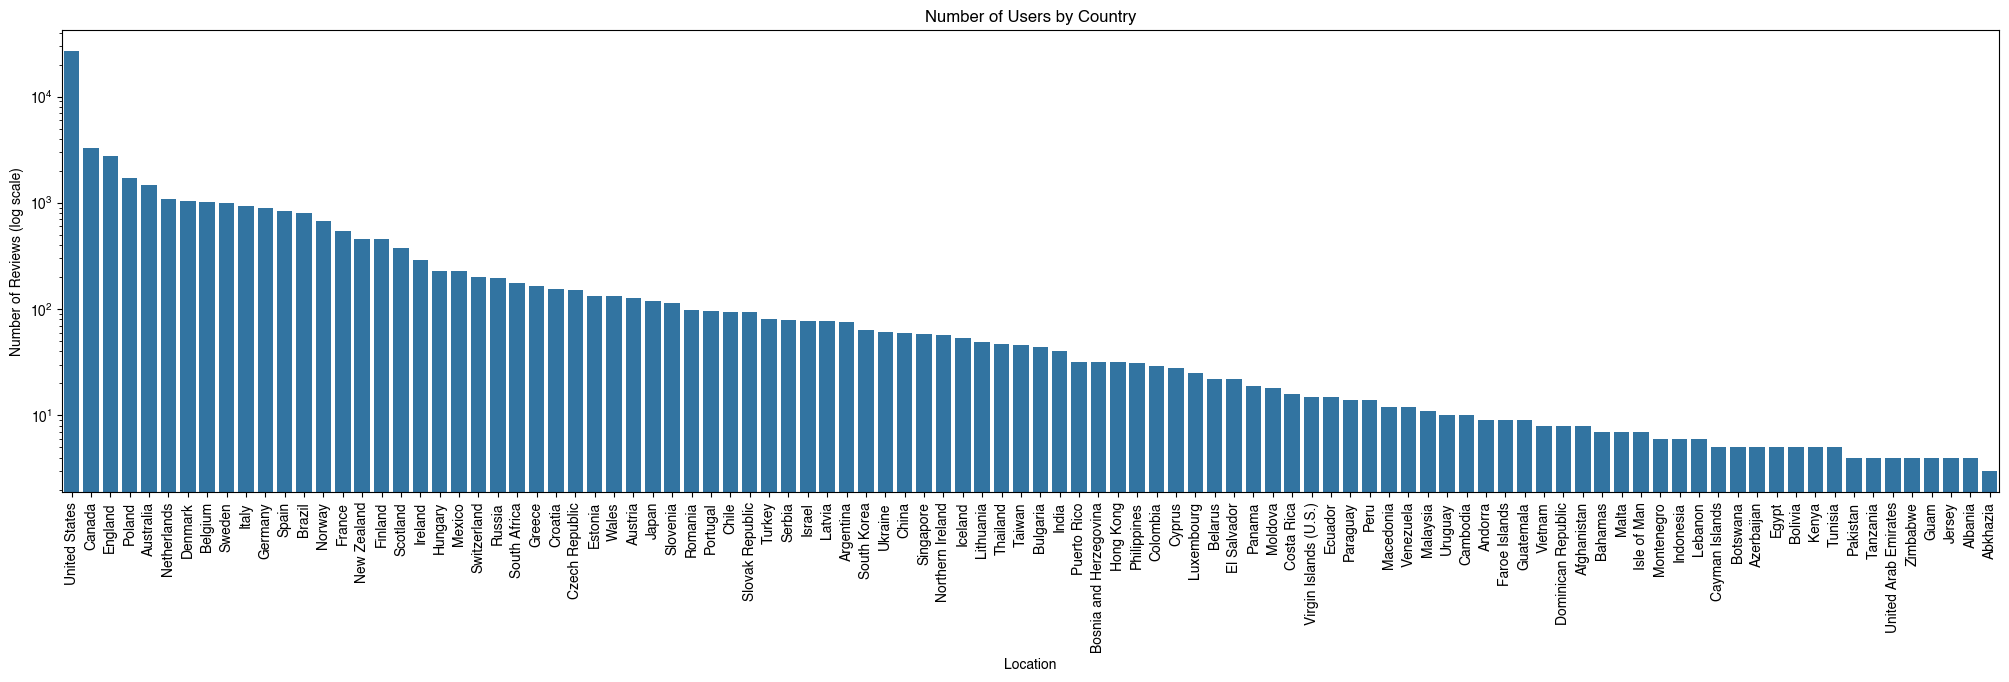

In [64]:
num_users = users_df.groupby('merged_location').size().sort_values(ascending=False).reset_index(name='nbr_users')

# remove unknown
num_users = num_users[num_users['merged_location'] != 'Unknown']

plt.figure(figsize=(25,6))
sns.barplot(x='merged_location', y='nbr_users', data=num_users.head(100), color='#1f77b4')
plt.xlabel('Location')
plt.ylabel('Number of Reviews (log scale)')
plt.yscale('log')
plt.title('Number of Users by Country')
plt.xticks(rotation=90)
plt.show()

While the numbers of users predominantly originate from the US, we see that a large number of users also come from Europe, i.e. England, Poland and even Denmark! 

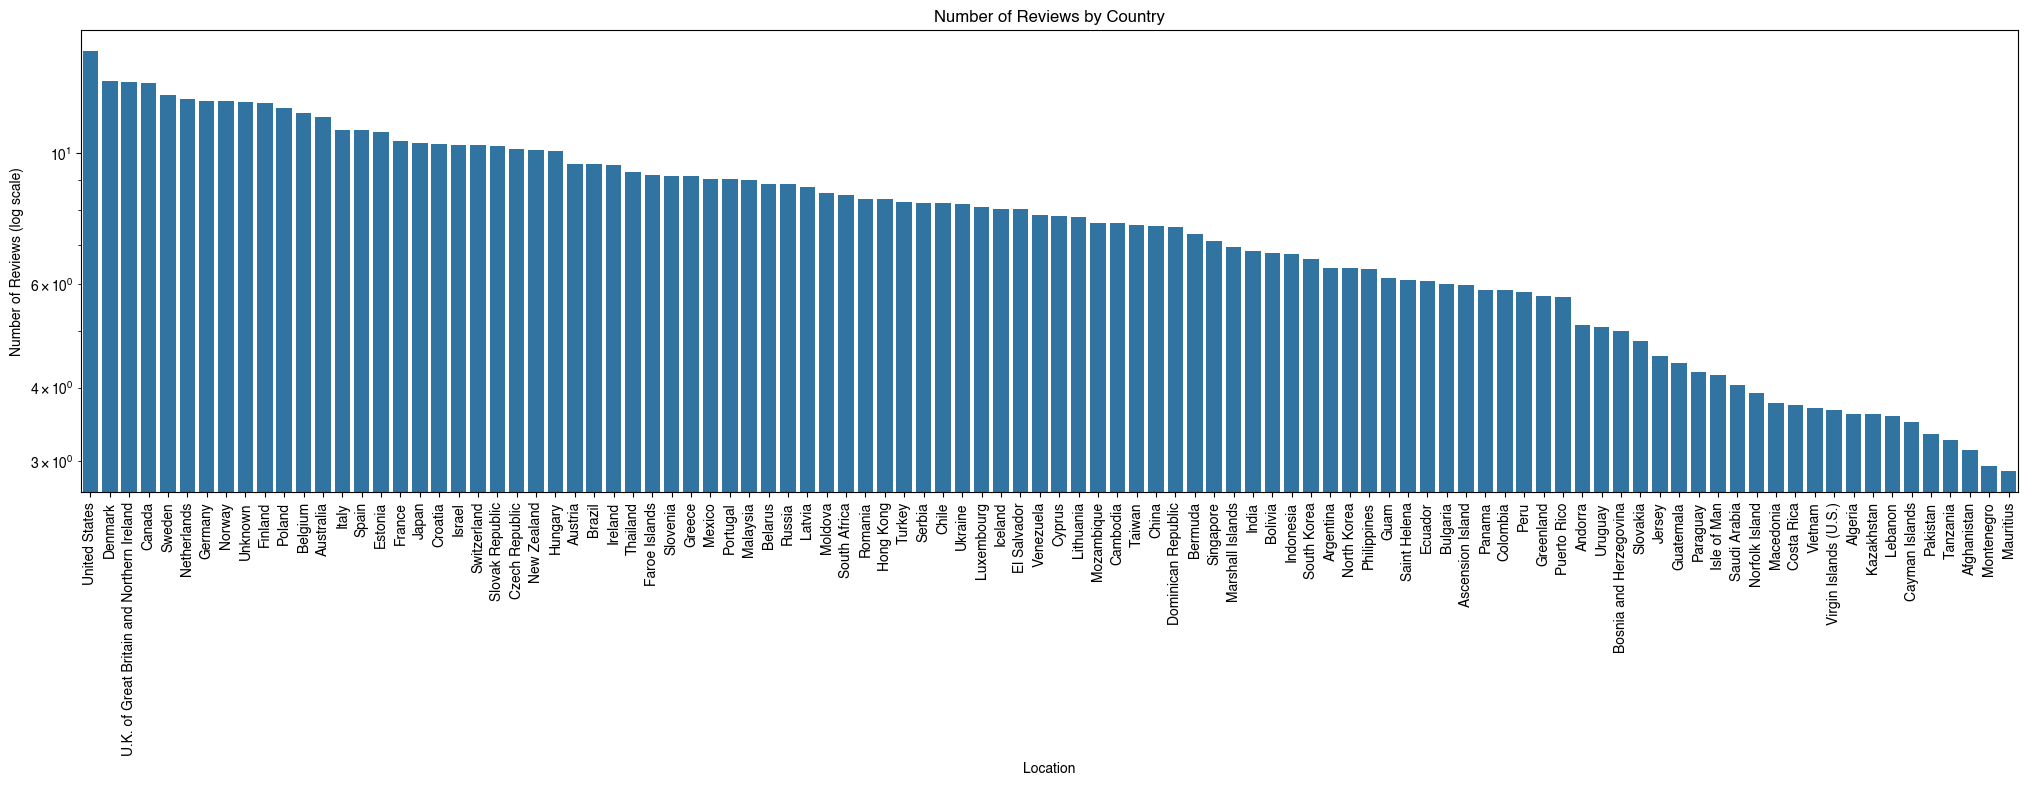

In [54]:
locations_df = users_breweries_reviews_df.groupby(['user_location']).aggregate({'user_id':'count'}).sort_values(by='user_id', ascending=False).reset_index()
locations_df['nbr_reviews_log'] = np.log(locations_df['user_id'])
locations_df = locations_df.rename({"user_id": "nbr_reviews"}, axis=1)
locations_df.head(10)

plt.figure(figsize=(25,6))
sns.barplot(x='user_location', y='nbr_reviews_log', data=locations_df.head(100), color='#1f77b4')
plt.xlabel('Location')
plt.ylabel('Number of Reviews (log scale)')
plt.yscale('log')
plt.title('Number of Reviews by Country')
plt.xticks(rotation=90)
plt.show()


Fortunately, it appears that other countries are also quite active on RateBeer's platform, showing engagement levels comparable to those of the US, which is predominantly active.

# 3. Data Analysis

## 3.1: General Findings from Analysis

The exploratory data analysis and statistics presented earlier, along with the visualizations featured on the website and in subsequent sections, revealed unexpected insights. Contrary to our initial assumptions that countries like Germany, the Czech Republic, and Denmark would rank among the highest, it was surprising to find Norway leading. This discrepancy could be attributed to several factors, including the number of beers produced by the country and the volume of country-specific reviews, as illustrated in the histograms.


Additionally, despite Asia's substantial brewery count, it is underrepresented in the dataset due to its predominantly Western authorship, which may lack detailed knowledge about Asian breweries. Moreover, this misrepresentation is exacerbated in the free-text review analysis, as the filtering process excludes non-English words as well as for the geoplots. These issues are further explored in the next section.









## 3.2: Natural Language Processing
Each row in users_breweries_reviews_df contains free-text reviews. We use the Python package nltk to filter these reviews, retaining only those in English. This involves the use of English stopwords and other defined stopwords to refine our analysis. Consequently, the total number of reviews is reduced since those in other languages are excluded. While this filtering impacts the breadth of the sentiment analysis, it enables a more focused examination of descriptions in a common language like English, which we anticipate will be present in reviews from each country.


In [ ]:
# Load the language detector and sentiment analyzer
detector = LanguageDetectorBuilder.from_all_languages().build()
sia = SentimentIntensityAnalyzer()

# Create dictionaries for the brewery and user data to map to the reviews
brewery_dict = dict(zip(df_breweries['name'], df_breweries['location'])) 
user_dict = dict(zip(df_users['user_name'], df_users['location']))

# Load the stopwords and add some additional ones to fit the theme - This is not all-encompassing, but it is hopefully good enough
stop_words = set(stopwords.words('english'))
additional_stop_words = ['beer', 'beers', 'tap', 'pour', 'pours', 'bottle', 'bottles',
                         'sample', 'cl', 'oz', 'ml', 'draft', 'glass', 'drink', 'drinks', 'shared', 'share', 'local', 'locals', 'aroma','smell','smells','smelling','smelled','taste','tastes','tasting','tasted','palate','mouthfeel','mouth','feel','feeling','feels',
                         'black', 'brown', 'red', 'yellow', 'white', 'orange', 'green', 'blue', 'purple', 'pink', 'color', 'colors','dark','light','lighter','darker','lightest','darkest','lightest','darkest','lightest','darkest','lightest','darkest','lightest','darkest',
                         'thanks', 'thx','thnx', 'flavor', 'flavour', 'flavors', 'flavours', 'note', 'notes', 'nose', 'noses', 'nosing', 'nosed', 'head', 'heads', 'heady', 'headier']
stop_words.update(additional_stop_words)

# 4. Genre

The beer data have interesting angles, so therefore it could be favourable to describe the data-driven story using a magazine genre. The narative structure follows the martini glass such that the first part of the story is presented with staitc plots and in an author-driven narative. As the reader delves into the story, more interactive plots become present and the user will be able to explore further and interpret the results of the analysis. 

## 4.1 Visual Narrative


### Visual structuring

For visual structuring, we have employed *Consistent Visual Platform*, by utilizaing a consistent color scheme.

### Highlighting

Further, we have employed *Highlighting* by using *Close-up* in the form of supplementary figures for the interactive plots, to highlight interesting features in the plots.


### Transition guidance

Finally, we have employed *Familiar Objects* as transition guidance.
Generally, we only employ the same kind of plots, in a subsection, and keep the coloring, e.g. by administrative region, consistent across the plots. This allows the reader to easily compare the plots, and to easily interpret the plots.


## 4.2 Narative structure

### Ordering

The story is linear, ideal for web navigation, where readers naturally progress from top to bottom, building on information from previous sections.


### Interactivity

Tools like Hover Highlighting on interactive plots and Selection on choropleth maps enhance user engagement, allowing detailed exploration and easy movement between sections.

### Messaging

The use of Headlines, Annotations, and Accompanying Articles organizes content clearly, introduces data visualizations effectively, and summarizes key findings, ensuring the story is accessible and informative.

# 5. Visualizations
Following the Martini Glass structure, we now will explain why these plots have been chosen.

## 5.1 Surface Plots

To ease readers into the main story and the underlying dataset, we begin with static bar plots and histograms. These visuals illustrate the average beer ratings by country and the distribution of users and breweries by location, providing a foundational overview. Additionally, we include histograms to analyze the spread of ratings, offering insights into how distribution variations across countries can influence average ratings.

<img src="plots/average_beers.png" width="300" height="200" alt="Bubble Plot">
<img src="plots/most_active_users.png" width="300" height="200" alt="Bubble Plot">
<img src="plots/most_breweries.png" width="300" height="200" alt="Bubble Plot">
<img src="plots/histogram.png" width="300" height="200" alt="Bubble Plot">



In [ ]:
# List of US state names
merged_data = pd.merge(beers_data, breweries_data, left_on='brewery_id', right_on='id')

# Filterering out beers with less than 200 reviews to ensure popularity (this is to include only those beers that have received at least 200 ratings).
# This is to ensure that the average ratings are statistically significant and not based on a very small number of reviews.
merged_data = merged_data[merged_data['nbr_ratings'] >= 200]

# Calculating weighted averages for each beer. 
# This is to help emphasizing beers rated by a larger number of reviewers.
merged_data['weighted_avg'] = merged_data['avg'] * merged_data['nbr_ratings']

# Grouping by location, then aggregate the necessary metrics.
# This sums up the weighted averages and total number of ratings for beers within each country.
location_avg_ratings = merged_data.groupby('merged_location').agg({
    'weighted_avg': 'sum',
    'nbr_ratings': 'sum'
})

# Calculating the average rating for each location
location_avg_ratings['average_rating'] = location_avg_ratings['weighted_avg'] / location_avg_ratings['nbr_ratings']

# Filtering locations with a significant number of reviews (at least 200) again
# We again use a filter, where locations with at least 200 total ratings are further filtered to ensure quality of the aggregated data.
location_avg_ratings = location_avg_ratings[location_avg_ratings['nbr_ratings'] >= 200]

# Getting the top locations based on average rating.
top_locations = location_avg_ratings.nlargest(30, 'average_rating')

# Plotting the top locations
plt.figure(figsize=(16, 9))
plt.bar(top_locations.index, top_locations['average_rating'], color='orange', edgecolor='black')
plt.title('Top Locations by Average Beer Rating', fontsize=16, fontweight='bold')
plt.xlabel('Location', fontsize=14)
plt.ylabel('Average Beer Rating', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
for i, v in enumerate(top_locations['average_rating']):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', color='black', fontweight='bold', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# Grouping the data by 'location' and count the number of unique breweries in each location
brewery_counts = breweries_data.groupby('merged_location')['id'].nunique().reset_index()
brewery_counts.columns = ['location', 'count']

# Selecting the top locations with the most breweries
top_locations = brewery_counts.nlargest(30, 'count')

# Plotting the top locations
plt.figure(figsize=(16, 9))
bars = plt.bar(top_locations['merged_location'], top_locations['count'], color='orange', edgecolor='black')
plt.title('Top Locations with the Most Breweries', fontsize=16, fontweight='bold')
plt.xlabel('Location', fontsize=14)
plt.ylabel('Number of Breweries', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Setting the y-axis to a logarithmic scale
plt.yscale('log')

# Adding annotations on each bar for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{int(yval)}", va='bottom', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Filtering out rows with NaN values in the 'location' column
users_data = users_data[~users_data['location'].str.contains('nan', case=False, na=False)]

users_data['location'] = users_data['location'].astype(str)
users_data['location'] = users_data['location'].apply(
    lambda x: 'United States' if any(state in x for state in us_states) else x)

# Grouping the data by 'location' and count the number of user in each location
location_activity = users_data.groupby('location')['user_id'].nunique().reset_index(name='active_users')

# Selecting the top locations with the most active users
top_locations = location_activity.sort_values(by='active_users', ascending=False).head(30)

# Plotting the top locations
plt.figure(figsize=(16, 9))
bars = plt.bar(top_locations['location'], top_locations['active_users'], color='orange', edgecolor='black')
plt.title('Top Locations with the Most Active Users', fontsize=16, fontweight='bold')
plt.xlabel('Location', fontsize=14)
plt.ylabel('Number of Active Users', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Seting the y-axis to a logarithmic scale
plt.yscale('log')

# Adding annotations on each bar for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{int(yval)}", va='bottom', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# Ignoring warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
np.seterr(divide='ignore', invalid='ignore')

# Filtering Norway breweries
norway_breweries = breweries_data[breweries_data['location'] == 'Norway']
norway_beers = pd.merge(beers_data, norway_breweries, left_on='brewery_id', right_on='id', how='inner')

# Filtering Germany breweries
germany_breweries = breweries_data[breweries_data['location'] == 'Germany']
germany_beers = pd.merge(beers_data, germany_breweries, left_on='brewery_id', right_on='id', how='inner')

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 9))

# Plotting histogram for Norway beer ratings
sns.histplot(data=norway_beers, x='avg', bins=30, color='orange', kde=True, edgecolor='black', alpha=0.7, binrange=(1, 5), ax=axes[0])
axes[0].lines[0].set_color('blue')
axes[0].lines[0].set_linewidth(2)
axes[0].set_title('Norway Beer Ratings', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Global Rating', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].set_xlim(1, 5)
axes[0].set_xticks(range(1, 6))
axes[0].grid(False)

# Plotting histogram for Germany beer ratings
sns.histplot(data=germany_beers, x='avg', bins=30, color='orange', kde=True, edgecolor='black', alpha=0.7, binrange=(1, 5), ax=axes[1])
axes[1].lines[0].set_color('blue')
axes[1].lines[0].set_linewidth(2)
axes[1].set_title('Germany Beer Ratings', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Global rating', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].set_xlim(1, 5)
axes[1].set_xticks(range(1, 6))
axes[1].grid(False)

plt.tight_layout()
plt.show()

## 5.2 Ratio/Area Plot

To gauge the enthusiasm and innovation of a country in beer crafting, we use a ratio of breweries to the country's area. This ratio provides an indication of how densely breweries are distributed within a region. We visualize this data with a bubble plot, where the size of each bubble is proportionate to the ratio, effectively demonstrating the concentration of breweries. The axes of the plot represent the underlying factors of the ratio, enhancing understanding of the data's context.

<img src="plots/bubble_plot.png" width="600" height="400" alt="Bubble Plot">

### Data Wrangling
Needed to match countries in the `breweries_df` with the `https://restcountries.com/v3.1/all`

In [6]:
# url country area in km^2
url = 'https://restcountries.com/v3.1/all'

# Send a request to the API
response = requests.get(url)
data = response.json()

# Extract country names and areas
country_areas = [{'name': country['name']['common'], 'area': country['area']} for country in data if 'area' in country]
country_area_df = pd.DataFrame(country_areas)

breweries_df.rename(columns = {'name':'brewery_name'}, inplace = True)
breweries_df['merged_location'] = breweries_df['location'].copy()
breweries_df.loc[(breweries_df['merged_location'].str.startswith('United States')), 'merged_location'] = 'United States'
breweries_df.loc[breweries_df["merged_location"].isin(["Northern Ireland", "Scotland", "England", "Wales"]), "merged_location"] = "United Kingdom"
breweries_df.loc[breweries_df["merged_location"].isin(["Czech Republic", "Czechia"]), "merged_location"] = "Czechia"
breweries_df.loc[breweries_df["merged_location"].isin(["Slovak Republic"]), "merged_location"] = "Slovakia"
breweries_ratio_df = breweries_df.groupby('merged_location').size().reset_index()

# only look at countries with breweries 5+ 
breweries_ratio_df = breweries_ratio_df[breweries_ratio_df[0] > 5]

# merge dataframes
ratio_area_df = breweries_ratio_df.merge(df, left_on='merged_location', right_on='name', how='left').sort_values(by='area', ascending=False)

# change name of column 0 to count
ratio_area_df.rename(columns={0: 'count'}, inplace=True)

# calculate area per 500 km2 and ratio
ratio_area_df['area_500km2'] = ratio_area_df['area'] / 500
ratio_area_df['ratio'] = ratio_area_df['count'] / ratio_area_df['area_500km2']

# remove nan values
ratio_area_df = ratio_area_df.dropna()

In [ ]:
#  bubble plot of breweries per area
fig = px.scatter(ratio_area_df, y='count', x='area_500km2', 
                 size='ratio', color='ratio', hover_name='merged_location', 
                 labels={'area_500km2':'Area Per 500 km²', 'ratio':'Breweries Per 500 km²'
                         , 'count':  'Breweries'}, 
                 size_max=50, text = ratio_area_df['merged_location'],
                 width = 1100,
                 height= 700)

# change x-axis to log scale
# put label on each bubble with the country name
fig.update_traces(textposition='top center', showlegend=False, text=ratio_area_df['merged_location'], textfont=dict(family="Arial", size=8, color="black"))
fig.update_xaxes(type='log')
fig.update_yaxes(type='log')
# Update layout for vertical legend
fig.update_layout(
    legend=dict(
        orientation="v"
    )
)

fig.update_layout()
fig.show()

## 5.3 Choropleth Plot
To enhance interactivity, we transformed our initial bar plots into a choropleth plot. This allows users to toggle between different countries and explore perceptions of country-specific breweries. This interactive feature encourages users to draw their own conclusions by examining various data combinations. However, there were limitations to the number of countries we could include due to computational constraints. We selected the countries we found most intriguing based on our initial analysis, aiming to provide a meaningful yet manageable dataset for exploration.

<img src="plots/choropleth_plot.png" width="600" height="400" alt="Choropleth Plot">


In [10]:
# load country geometries (polygons)

with open('world-administrative-boundaries.geojson') as f:
    world = json.load(f)

# Let's only look at beers that have been reviewed at least 200 times
beer_ids_df = beer_df[beer_df['nbr_ratings'] >= 200].beer_id

# Filter beer_reviews_df to only include beers that have been reviewed at least 200 times
common_beer_reviews_df = users_breweries_reviews_df[users_breweries_reviews_df['beer_id'].isin(beer_ids_df)].reset_index()

# group by brewery location and take mean of the rating for each location
country_brewery_rating = common_beer_reviews_df.groupby('brewery_location')['rating'].mean().reset_index()


# list of deepdive countries
deepdive_countries = ['United States', 'Denmark', 'Belgium', 'Germany', 'Italy',
                      'Czech Republic', 'U.K. of Great Britain and Northern Ireland', 'Canada', 'China', 'Norway', 'Sweden']

for country in deepdive_countries:

    # calculate users opinion in country average rating by beers from specific country
    temp_common_beer_df = common_beer_reviews_df[common_beer_reviews_df['user_location']==country]
    
    # calculate country average rating by beers from specific country
    country_specific_rating_df = temp_common_beer_df.groupby('brewery_location')['rating'].mean().reset_index()
    
    merged_df = pd.merge(country_brewery_rating, country_specific_rating_df, on='brewery_location', suffixes=('_overall', '_specific'), how='outer')
    
    # if row value in 'brewery_location' for both country_specific_rating and country_brewery_rating_test is equal,
    # calculate the difference between the two ratings
    country_brewery_rating[country + '_opinion_diff'] = merged_df['rating_specific'] - merged_df['rating_overall']
    
# add a column with ISO3 country codes
country_brewery_rating['iso3'] = coco.convert(names=country_brewery_rating['brewery_location'], to='ISO3')

In [ ]:
# list of countries for choropleth map
countries = ['United States_opinion_diff', 'Denmark_opinion_diff', 'China_opinion_diff', 
             'Belgium_opinion_diff', 'Germany_opinion_diff', 'Italy_opinion_diff', 
             'Czech Republic_opinion_diff', 'U.K. of Great Britain and Northern Ireland_opinion_diff', 
             'Canada_opinion_diff', 'Norway_opinion_diff', 'Sweden_opinion_diff']

countries_diff = ['Denmark_opinion_diff', 'China_opinion_diff', 'Belgium_opinion_diff', 
                  'Germany_opinion_diff', 'Italy_opinion_diff', 'Czech Republic_opinion_diff', 
                  'U.K. of Great Britain and Northern Ireland_opinion_diff', 'Canada_opinion_diff', 
                  'Norway_opinion_diff', 'Sweden_opinion_diff']

label_dict = {'United States_opinion_diff': 'Country Opinion: US', 
              'Denmark_opinion_diff': 'Country Opinion: Denmark', 
              'Belgium_opinion_diff': 'Country Opinion: Belgium', 'Germany_opinion_diff': 'Country Opinion: Germany', 
              'Italy_opinion_diff': 'Country Opinion: Italy', 'Czech Republic_opinion_diff': 'Country Opinion: Czech Republic', 
              'U.K. of Great Britain and Northern Ireland_opinion_diff': 'Country Opinion: UK', 
              'Canada_opinion_diff': 'Country Opinion: Canada', 'China_opinion_diff': 'Country Opinion: China',
              'Norway_opinion_diff': 'Country Opinion: Norway', 'Sweden_opinion_diff': 'Country Opinion: Sweden'}


def make_choropleth(df, title, height, width):
    fig = go.Figure()
    
    # first figure is the global rating
    fig.add_trace(go.Choroplethmapbox(
        geojson=world,
        locations=df['iso3'],
        z = df['United States_opinion_diff'],
        zauto=True,
        colorscale = 'RdYlGn_r',
        text=df['brewery_location'],
        reversescale=True,
        marker=dict(opacity=0.5),
        colorbar={"title": "Opinion Difference: US and Global Rating", "titleside": "right"},
        hovertemplate='<b>%{text}<br> %{z}<extra></extra>',
        featureidkey='properties.iso3')
    )
    
    for country_diff in countries_diff:
        min, max = df[country_diff].quantile([0.05, 1])

        fig.add_trace(go.Choroplethmapbox(
            geojson=world,
            locations=df['iso3'],
            z = df[country_diff],
            zmin= min,
            zmax= max,
            colorscale = 'RdYlGn_r',
            marker=dict(opacity=0.5),
            text=df['brewery_location'],
            reversescale=True,
            visible=False,
            colorbar={"title": f"Opinion Difference: {country_diff.split('_')[0]} and Global Rating", "titleside": "right"},
            hovertemplate='<b>%{text}<br> %{z}<extra></extra>',
            featureidkey='properties.iso3')
        )
    

    fig.update_layout(
        mapbox_style="carto-positron",
        mapbox_zoom=0,
        mapbox_center={"lat": 56.2, "lon": 10.5683},
    )

    buttons_list = []

    for i, name in enumerate(countries):
        visibility = [False] * len(countries)  # Start with all false
        visibility[i] = True  # Only the selected dataset is visible
        button = dict(
            label=label_dict[name],
            method="update",
            args=[{"visible": visibility}])
        buttons_list.append(button)
        

# Add dropdown to the layout
    fig.update_layout(
        updatemenus=[
            dict(
                active=0,
                buttons = list(
                    buttons_list
  
                ),
            ),
        ]
    )


    # Add a title
    fig.update_layout(title_text=title, coloraxis_showscale=False)
    fig.data[0].update(showscale=True)  # Show color scale for the first trace initially

    

    # Pad colorbar, so title length does not affect the width of the map
    fig.update_layout(coloraxis_colorbar=dict(lenmode="pixels", len=300))
    fig.update_layout(height=height, width=width)

    return fig

fig = make_choropleth(country_brewery_rating, " ", 800, 1000)
fig.show()

## 5.4: Tree Map Plot

Initially, we considered using word clouds to display the top 10 words associated with the best and worst beers. However, encountering challenges in presenting this information effectively and engagingly, we shifted to a tree map plot. This approach greatly enhances interactivity, focusing on the top 10 words for the 5 highest-rated and 5 lowest-rated beers from 12 different countries rated by a specific country, providing a complex $12^2 \cdot 2 \cdot 5$ combinations. This rich interactivity makes the tree map plot the final visual in our story, designed to empower users to conduct their own explorations, following the martini glass structure of our narrative.

<img src="plots/treemap_plot.png" width="600" height="400" alt="Bubble Plot">



In [ ]:
# Load the language detector and sentiment analyzer
detector = LanguageDetectorBuilder.from_all_languages().build()
sia = SentimentIntensityAnalyzer()

# Create dictionaries for the brewery and user data to map to the reviews
brewery_dict = dict(zip(df_breweries['name'], df_breweries['location'])) 
user_dict = dict(zip(df_users['user_name'], df_users['location']))

# Load the stopwords and add some additional ones to fit the theme - This is not all-encompassing, but it is hopefully good enough
stop_words = set(stopwords.words('english'))
additional_stop_words = ['beer', 'beers', 'tap', 'pour', 'pours', 'bottle', 'bottles',
                         'sample', 'cl', 'oz', 'ml', 'draft', 'glass', 'drink', 'drinks', 'shared', 'share', 'local', 'locals', 'aroma','smell','smells','smelling','smelled','taste','tastes','tasting','tasted','palate','mouthfeel','mouth','feel','feeling','feels',
                         'black', 'brown', 'red', 'yellow', 'white', 'orange', 'green', 'blue', 'purple', 'pink', 'color', 'colors','dark','light','lighter','darker','lightest','darkest','lightest','darkest','lightest','darkest','lightest','darkest','lightest','darkest',
                         'thanks', 'thx','thnx', 'flavor', 'flavour', 'flavors', 'flavours', 'note', 'notes', 'nose', 'noses', 'nosing', 'nosed', 'head', 'heads', 'heady', 'headier']
stop_words.update(additional_stop_words)

# Take the text from reviews, detect if it is english, tokenize it, and remove stopwords.
def clean_text(text):
    detection = detector.detect_language_of(text)

    if not detection:
        return None
    if detection.name == 'ENGLISH':
        words = text.split(' ')
        words = [word.lower() for word in words if word.isalpha()]
        words = [word for word in words if word not in stop_words]
        return words
    else:
        return None

# Check if the text is in English
def check_eng(text):
    if detector.detect_language_of(text).name == 'ENGLISH':
        return True
    else:
        return False

# Create a dataset with the average ratings for each beer
def create_avg_dataset(df_reviews_):
        
    # Average the reviews by beer_id
    df_reviews_['rating'] = df_reviews_['rating'].astype(float)

    # Sort out all of the beers with less than 30 reviews
    df_reviews_['count'] = df_reviews_.groupby('beer_id')['beer_id'].transform('count')
    df_reviews_less = df_reviews_[df_reviews_['count'] > 200]
    df_reviews_.drop('count', axis=1, inplace=True)

    # Average the ratings for each beer
    average_ratings = df_reviews_less.groupby(['beer_name', 'brewery_name'])['rating'].mean().reset_index()
    average_ratings.sort_values('rating', ascending=False, inplace=True)

    # Add location to average_ratings
    average_ratings['location'] = average_ratings['brewery_name'].map(brewery_dict)
    
    return average_ratings


def get_best_worst(average_ratings, country_from, country_to):

    # Get the best and worst beers from the country
    country_beers = average_ratings[average_ratings['location'].str.contains(country_from)]
    country_beers_best = country_beers.head(5)
    country_beers_worst = country_beers.tail(5)

    # Get the names of the best and worst beers
    best_beer_names = country_beers['beer_name'].values
    worst_beer_names = country_beers_worst['beer_name'].values

    # Get the text reviews for the best beer
    best_beer_reviews_df = df_reviews_[df_reviews_['beer_name'].str.contains('|'.join(list(country_beers_best['beer_name'])))]
    best_beer_reviews = best_beer_reviews_df['text']
    best_beer_reviews_df['user_location'] = best_beer_reviews_df['user_name'].map(user_dict)

    # Get the text reviews for the worst beer
    worst_beer_reviews_df = df_reviews_[df_reviews_['beer_name'].str.contains('|'.join(list(country_beers_worst['beer_name'])))]
    worst_beer_reviews = worst_beer_reviews_df['text']
    worst_beer_reviews_df['user_location'] = worst_beer_reviews_df['user_name'].map(user_dict)

    # Get the reviews from a specific country
    country_reviews_best = best_beer_reviews_df[best_beer_reviews_df['user_location'].str.contains(country_to, na=False)]
    country_reviews_worst = worst_beer_reviews_df[worst_beer_reviews_df['user_location'].str.contains(country_to, na=False)]

    # If there are no reviews from the country, we insert a row with the beer name, text, count = 0, and user_location
    if len(country_reviews_best) == 0:
        print("No 'Best' reviews from this country")
        country_reviews_best = pd.DataFrame({'beer_name': ['No Reviews'], 'text': ['No Reviews'], 'count': [0], 'user_location': [country_to]})
    if len(country_reviews_worst) == 0:
        print("No 'worst' reviews from this country")
        country_reviews_worst = pd.DataFrame({'beer_name': ['No Reviews'], 'text': ['No Reviews'], 'count': [0], 'user_location': [country_to]})

    return country_beers_best, country_beers_worst, \
        best_beer_names, worst_beer_names, country_reviews_best, \
            country_reviews_worst, best_beer_reviews, worst_beer_reviews, \
                best_beer_reviews_df, worst_beer_reviews_df


def get_word_counts(best_beer_names, worst_beer_names, country_reviews_best, country_reviews_worst):
    best_beer_counts = []
    worst_beer_counts = []
    for beer_names in zip(best_beer_names, worst_beer_names):
        # Extract the reviews for the beer
        reviews_best = country_reviews_best[country_reviews_best['beer_name'] == beer_names[0]]['text']
        reviews_worst = country_reviews_worst[country_reviews_worst['beer_name'] == beer_names[1]]['text']

        # Clean the text and drop the NaN values such that we are left with only english words
        cleaned_text_best = reviews_best.apply(clean_text)
        cleaned_text_best.dropna(inplace=True)
        cleaned_text_worst = reviews_worst.apply(clean_text)
        cleaned_text_worst.dropna(inplace=True)
        #print(cleaned_text_worst)

        # Count the words in the reviews
        all_words_best = []
        all_words_worst = []
        for words in cleaned_text_best:
            all_words_best += words
        count = Counter(all_words_best)
        best_beer_counts.append(count)

        # Count the words in the reviews
        for words in cleaned_text_worst:
            all_words_worst += words
        count = Counter(all_words_worst)
        worst_beer_counts.append(count)
    
    return best_beer_counts, worst_beer_counts


def make_final_df(country_beers_best, country_beers_worst, best_beer_counts, worst_beer_counts, best_beer_reviews_df, worst_beer_reviews_df):
    best_beers_final_df = pd.DataFrame()

    # For each beer, we get the 10 most common words and their counts
    for i, beer_name in enumerate(list(country_beers_best['beer_name'])):
        count = best_beer_counts[i]
        count = dict(sorted(count.items(), key=lambda item: item[1], reverse=True)[:10])
        count = pd.DataFrame(count.items(), columns=['word', 'count'])
        count['beer_name'] = f"#{i+1} " + beer_name
        count['best_worst'] = 'Best'
        
        # If there are no reviews, then we insert a row such that it still pops up in the tree map, but with a single entry 'No Reviews'
        if len(best_beer_counts[i]) == 0:
            count = pd.DataFrame({'word': ['No Reviews'], 'count': [1], 'beer_name': [f"#{i+1} " + beer_name], 'best_worst': ['Best'], 'Positivity percentage': [0.5], 'Negativity percentage': [0.5]})
        else:
            positive_scores = []
            negative_scores = []
            
            # For each word, we calculate the positivity and negativity percentage of that word in context of all reviews
            # This gives us an idea if a word is generally used in a positive or negative context - There is some room for improvmenent here.
            for word in count['word']:
                pos = 0
                neg = 0
                #neu = 0
                for review in best_beer_reviews_df[best_beer_reviews_df['beer_name'] == beer_name]['text']:
                    if word in review and check_eng(review):
                        sentiment = sia.polarity_scores(review)
                        pos += sentiment['pos']
                        neg += sentiment['neg']
                        # We decided to not use neutral sentiment, as it is not as informative/fun as the other two - The sentiment for this is often too high
                        #neu += sentiment['neu']
                    
                    # Normalize these to add up to 1
                    total_score = pos + neg #+ neu
                    if total_score != 0:
                        pos /= total_score
                        neg /= total_score
                        #neu /= total_score


                positive_scores.append(pos)
                negative_scores.append(neg)
                #neutral_scores.append(neu)
            count['Positivity percentage'] = positive_scores
            count['Negativity percentage'] = negative_scores
            #count['neutral'] = neutral_scores
            #print(count)
        best_beers_final_df = pd.concat([best_beers_final_df, count], ignore_index=True)
    # END BEST
    # The exact same thing is done for the worst beers
    worst_beers_final_df = pd.DataFrame()

    for i, beer_name in enumerate(list(country_beers_worst['beer_name'])):
        count = worst_beer_counts[i]
        count = dict(sorted(count.items(), key=lambda item: item[1], reverse=True)[:10])
        count = pd.DataFrame(count.items(), columns=['word', 'count'])
        count['beer_name'] = f"#{i+1} " + beer_name
        count['best_worst'] = 'Worst'

        if len(worst_beer_counts[i]) == 0:
            count = pd.DataFrame({'word': ['No Reviews'], 'count': [1], 'beer_name': [f"#{i+1} " + beer_name], 'best_worst': ['Worst'], 'Positivity percentage': [0.5], 'Negativity percentage': [0.5]})
        else:
            positive_scores = []
            negative_scores = []
            for word in count['word']:
                pos = 0
                neg = 0
                #neu = 0
                for review in worst_beer_reviews_df[worst_beer_reviews_df['beer_name'] == beer_name]['text']:
                    if word in review and check_eng(review):
                        sentiment = sia.polarity_scores(review)
                        pos += sentiment['pos']
                        neg += sentiment['neg']
                        #neu += sentiment['neu']
                    
                    # Normalize these to add up to 1
                    total_score = pos + neg# + neu
                    if total_score != 0:
                        pos /= total_score
                        neg /= total_score
                        #neu /= total_score

                positive_scores.append(pos)
                negative_scores.append(neg)
                #neutral_scores.append(neu)
            count['Positivity percentage'] = positive_scores
            count['Negativity percentage'] = negative_scores
        #count['neutral'] = neutral_scores
 
        worst_beers_final_df = pd.concat([worst_beers_final_df, count], ignore_index=True)

    #print(worst_beers_final_df.to_string())
    #print(best_beers_final_df.to_string())
    
    final_df = pd.concat([best_beers_final_df, worst_beers_final_df], ignore_index=True)
        
    return final_df


def create_df_ez(average_ratings, country_from, country_to):
    # Use all of the beforementioned functions to create a dataframe we want easily
    country_beers_best, country_beers_worst, \
        best_beer_names, worst_beer_names, country_reviews_best, \
            country_reviews_worst, _, _, \
            best_beer_reviews_df, worst_beer_reviews_df = get_best_worst(average_ratings, country_from, country_to)

    best_beer_counts, worst_beer_counts = get_word_counts(best_beer_names, worst_beer_names, country_reviews_best, country_reviews_worst)

    final_df = make_final_df(country_beers_best, country_beers_worst, best_beer_counts, worst_beer_counts, best_beer_reviews_df, worst_beer_reviews_df)
    
    # Add data for the tree map plot to make the hierarchy work
    final_df['All countries'] = 'All countries'
    final_df['Review from'] = f"Reviews from {country_to}"
    final_df['Beers from'] = f"Beer from {country_from}"
    
    return final_df

In [ ]:
# Make the dataframe as needed - only has to be done once
average_ratings = create_avg_dataset(df_reviews_)

# The deepdrive countries initially chosen
deepdive_countries = ['United States', 'Denmark', 'Spain', 'Belgium', 'Germany', 'Italy',
                      'France', 'England', 'Canada', 'Australia']

country_combs = []

# Create all the combinations of countries we want to compare
for country in deepdive_countries:
    for country2 in deepdive_countries:
            country_combs.append((country, country2))
            
# Some extra countries added to the mix
extra_countries = ['Sweden', 'Norway']

all_countries = deepdive_countries + extra_countries

all_combs = []

# Create all the combinations of countries we want to compare
for country in all_countries:
    for country2 in all_countries:
        all_combs.append((country, country2))

# Filter out only such that the combs contain those of the extra countries
all_combs = [comb for comb in all_combs if comb[0] in extra_countries or comb[1] in extra_countries]

In [ ]:
# Create the hierarchical dataframe with just the extra added countries
# this takes quite long as well as we need to process the extra combinations
"""
huge_df_3 = pd.DataFrame()
for country_from, country_to in all_combs:
    print("Now starting with ", country_from, country_to)
    final_df = create_df_ez(average_ratings, country_from, country_to)
    huge_df_3 = pd.concat([huge_df_3, final_df], ignore_index=True)
    print("Done with", country_from, country_to, " Only", len(all_combs) - all_combs.index((country_from, country_to)), "left \n")

huge_df_3.to_csv('huge_df_3.csv', index=False)
"""

# Save the final dataframe to a csv
huge_df = pd.read_csv('huge_df.csv')
#huge_df_2 = pd.read_csv('huge_df_2.csv')
huge_df_3 = pd.read_csv('huge_df_3.csv')

huge_df = pd.concat([huge_df, huge_df_3], ignore_index=True)
#huge_df = pd.concat([huge_df, huge_df_3], ignore_index=True)

# Drop the rows which has Vietnam or Czech Republic or Spain as the country to and from
    # Initiall we had these two countries but decided they were too insignificant in terms of reviews
huge_df = huge_df[~huge_df['Review from'].str.contains('Vietnam|Czech Republic|Spain', na=False)]
huge_df = huge_df[~huge_df['Beers from'].str.contains('Vietnam|Czech Republic|Spain', na=False)]

# Change the column name for Positivity percentage to "Positivity %"
huge_df.rename(columns={'Positivity percentage': 'Positivity %'}, inplace=True)

# Create the treemap using Plotly - It has the following architecture
#testdf
# Reviews from ->
# Beers From ->
# [Best -> Beer names 
#           [Beer name #1 -> Words
#           [Beer name #2 -> Words ...

# [Worst -> Beer names
#           [Beer name #1 -> Words
#           [Beer name #2 -> Words ...

fig = px.treemap(huge_df, path=['All countries','Beers from','Review from', 'best_worst', 'beer_name', 'word'], 
                 values='count', 
                 color='Positivity %', color_continuous_scale='Oranges', 
                 title='', 
                 hover_data={'Positivity %':True, 'Negativity percentage':True}, color_continuous_midpoint=0.5,
                 maxdepth=2,
                 hover_name='Positivity %',
                 )#,
                 #hovertemplate='<b>%{count}<br>')

fig.update_traces(root_color="Black", 
                  hovertemplate='Word occurence in reviews: %{value:.0f}<br>Percentage of times word is positive: %{color}<br><extra>%{label}</extra>')
fig.data[0]['textfont']['size'] = 15

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

# Save fig
fig.write_html('Tree_plot.html')

fig.show()

# 6. Discussion

Overall, we believe we have crafted a cohesive story featuring a variety of visually appealing and diverse plot types, which enrich the reader's experience. Despite the technical challenges involved in creating these plots, we successfully navigated these complexities to deliver a polished final product.

## 6.1: Improvements and Limitations
To enhance our story, we could expand our analysis to include factors like beer exports and production rates, examining how these aspects influence ratings rather than relying solely on assumptions. Additionally, incorporating more recent data would make our narrative more relevant and contemporary, allowing readers to relate more closely to the findings. In terms of natural language processing (NLP), exploring alternative methods such as employing transformer networks for translating non-English reviews could have allowed us to include a broader range of perspectives by analyzing all reviews in a unified language, rather than excluding non-English data.


# 7. Contributions
All parts of this project have been made in collaboration between all group members. Everyone has been contributing in some way or another to all sections. In the following, we will state the main responsible for the individual sections of our website: 

## Website 
- Introduction: *Sarah*
- Data Story: *Asbjørn*
- Story Idea: *Asbjørn* & *Martin*
- Surface Plots [Bar plots + histograms]: *Sarah*
- Bubble Plot [Ratio : Breweries/Area]: *Martin*
- Choropleth Plots: *Martin*
- Tree Map Plots: *Asbjørn*

## Technical Aspect
- Website: *Sarah*
- Data Preprocessing: *Martin*
- Text Processing: *Asbjørn*


# 8. References
<a name="ref1">1</a>: Top 10 consumed beverages [https://nawon.com.vn/top-10-worlds-most-consumed-beverage/](https://nawon.com.vn/top-10-worlds-most-consumed-beverage/)

<a name="ref2">2</a>: Who invented beer [https://www.history.com/news/who-invented-beer](https://www.history.com/news/who-invented-beer)

<a name="ref3">3</a>: Where did beer originate from [https://www.brewscruise.com/blog/where-did-beer-originate-from/](https://www.brewscruise.com/blog/where-did-beer-originate-from/)

<a name="ref4">4</a>: Beer in different countries [https://craftbeerme.com/beer-in-different-countries/](https://craftbeerme.com/beer-in-different-countries/)

<a name="ref5">5</a>: Award winners [https://www.worldbeercup.org/winners/award-winners/](https://www.worldbeercup.org/winners/award-winners/)

<a name="ref6">6</a>: Leading 10 countries in worldwide beer production [https://www.statista.com/statistics/270269/leading-10-countries-in-worldwide-beer-production/](https://www.statista.com/statistics/270269/leading-10-countries-in-worldwide-beer-production/)

<a name="ref7">7</a>: Influence of transport and storage conditions on beer quality and flavour stability [https://onlinelibrary.wiley.com/doi/full/10.1002/jib.535](https://onlinelibrary.wiley.com/doi/full/10.1002/jib.535)
